# Atividade 4
## Análise exploratória de dados para desmatamento no estado de Minas Gerais para os meses de agosto e setembro de 2022

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
#leitura do arquivo json
path = 'D:/Projetos/Agronomiq/Teste_Adm/'
input_geojson = f"{path}focos-desmatamento-mg.geojson"
gdf = gpd.read_file(input_geojson)

In [ ]:
#orreção da coluna data para garantir o formato data
gdf['Data Final'] = pd.to_datetime(gdf['Data Final'], dayfirst=True)
gdf['geometry'] = gdf['geometry'].buffer(0)

## Qual a área total desmatada em hectares no estado de Minas Gerais em cada um dos meses de agosto e setembro de 2022

In [51]:
gdf_ago = gdf[gdf['Data Final'].dt.month == 8].copy()
gdf_ago['area'] = gdf_ago.geometry.area / 10000
area_total_agosto = gdf_ago['area'].sum()

gdf_set = gdf[gdf['Data Final'].dt.month == 9].copy()
gdf_set['area'] = gdf_set.geometry.area / 10000
area_total_setembro = gdf_set['area'].sum()

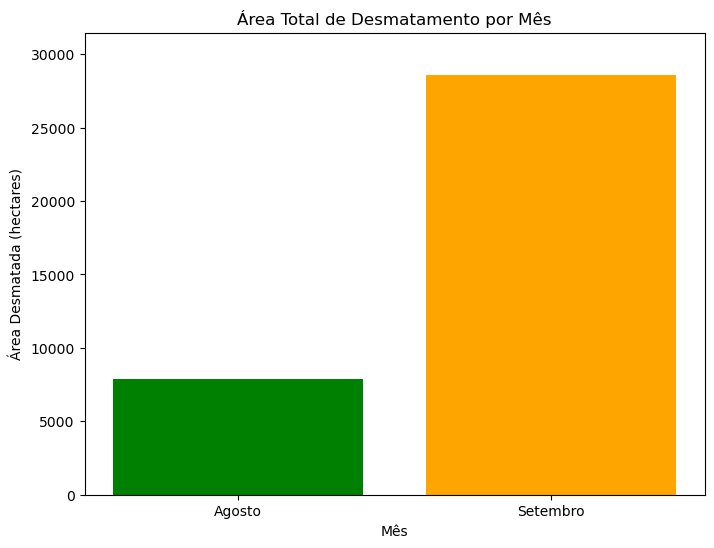

In [52]:
# gráfico para exibição dos resultados
meses = ['Agosto', 'Setembro']
areas = [area_total_agosto, area_total_setembro]

plt.figure(figsize=(8, 6))
plt.bar(meses, areas, color=['green', 'orange'])
plt.xlabel('Mês')
plt.ylabel('Área Desmatada (hectares)')
plt.title('Área Total de Desmatamento por Mês')
plt.ylim(0, max(areas) * 1.1)  # Ajustar o limite superior do eixo y
plt.show()

## Qual a área total desmatada em km² no estado de Minas Gerais em todo o período fornecido (ago/set de 2022) por bioma?


In [56]:
gdf_filtered = gdf[gdf['Data Final'].dt.month.isin([8, 9])].copy()
gdf_filtered['area'] = gdf_filtered.geometry.area / 100000

area_por_bioma = gdf_filtered.groupby('Bioma')['area'].sum().reset_index()

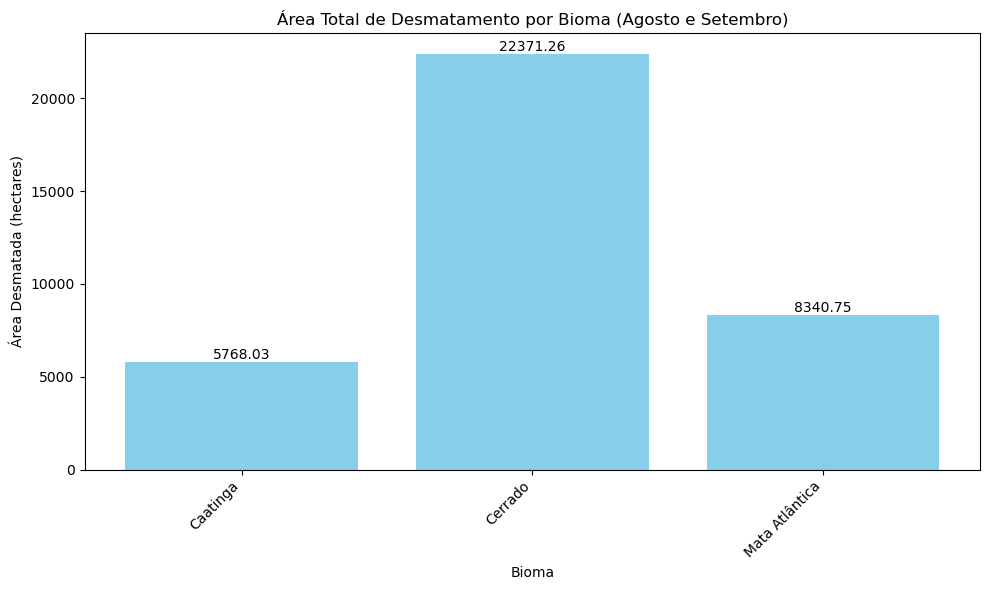

In [59]:
plt.figure(figsize=(10, 6))
bars = plt.bar(area_por_bioma['Bioma'], area_por_bioma['area'], color='skyblue')
plt.xlabel('Bioma')
plt.ylabel('Área Desmatada (hectares)')
plt.title('Área Total de Desmatamento por Bioma (Agosto e Setembro)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()

## Qual a área total desmatada em km² no estado de Minas Gerais em cada um dos meses de agosto e setembro de 2022, por município?

In [70]:
import geopandas as gpd
import pandas as pd

# Caminho para o arquivo GeoJSON
input_geojson = f"{path}municipios-mg.geojson"
gdf_municipios = gpd.read_file(input_geojson)

# Verificar e corrigir geometrias inválidas
gdf['Data Final'] = pd.to_datetime(gdf['Data Final'], dayfirst=True)
gdf['geometry'] = gdf['geometry'].buffer(0)
#gdf_municipios['geometry'] = gdf_municipios['geometry'].buffer(0)

# Certificar que ambos os GeoDataFrames têm o mesmo CRS
if gdf.crs != gdf_municipios.crs:
    gdf_municipios = gdf_municipios.to_crs(gdf.crs)

# Realizar a sobreposição
gdf_munic_desm = gpd.overlay(gdf, gdf_municipios, how='intersection')

# Filtrar para os meses de agosto e setembro
gdf_agosto_setembro = gdf_munic_desm[gdf_munic_desm['Data Final'].dt.month.isin([8, 9])].copy()

# Remover geometrias vazias
gdf_agosto_setembro = gdf_agosto_setembro[~gdf_agosto_setembro['geometry'].is_empty]

# Calcular a área em km²
gdf_agosto_setembro.loc[:, 'area_km2'] = gdf_agosto_setembro.geometry.area / 1000000

In [71]:
input_geojson = f"{path}municipios-mg.geojson"
gdf_municipios = gpd.read_file(input_geojson)
gdf_munic_desm = gpd.overlay(gdf, gdf_municipios, how='intersection')

gdf['Data Final'] = pd.to_datetime(gdf['Data Final'], dayfirst=True)
gdf['geometry'] = gdf['geometry'].buffer(0)

In [72]:
gdf_agosto_setembro = gdf_munic_desm[gdf_munic_desm['Data Final'].dt.month.isin([8, 9])].copy()
gdf_agosto_setembro.loc[:, 'area_km2'] = gdf_agosto_setembro.geometry.area / 1000000

In [75]:
nome_coluna_municipio = 'name'
coluna_id_municipio = 'id_2'

area_total_por_municipio = gdf_agosto_setembro.groupby([coluna_id_municipio, nome_coluna_municipio])['area_km2'].sum().reset_index()

desm_munic = 'desmatamento_municipio.csv'
area_total_por_municipio.to_csv(desm_munic, index=False)

area_total_por_municipio

,id_2,name,area_km2
0,3100104,Abadia dos Dourados,0.378671
1,3100203,Abaeté,0.210202
2,3100609,Água Boa,0.341885
3,3100708,Água Comprida,1.135686
4,3100906,Águas Formosas,0.262786
...,...,...,...
367,3171030,Verdelândia,2.714539
368,3171154,Vermelho Novo,0.026200
369,3171303,Viçosa,0.020150
370,3171808,Virginópolis,0.086231


## Análise de correlação entre as variáveis de população e PIB dos municípios de Minas Gerais e a área desmatada em hectares

In [77]:
import seaborn as sns
import requests

### Dados de população pelo IBGE

In [135]:
url = "https://servicodados.ibge.gov.br/api/v3/agregados/6579/periodos/2012/variaveis/9324?localidades=N1[all]|N6[N3[31]]"

response = requests.get(url)
data = response.json()

dados_extraidos = []

# extrair as informações desejadas
for resultado in data[0]['resultados']:
    for serie in resultado['series']:
        localidade = serie['localidade']
        id_municipio = localidade['id']
        nome_municipio = localidade['nome']
        populacao_2012 = serie['serie'].get('2012', None)  # Obter a população para 2024

        # Adicionar os dados extraídos à lista
        dados_extraidos.append({
            'id': id_municipio,
            'Municipio': nome_municipio,
            'Populacao 2012': populacao_2012
        })

df_pop = pd.DataFrame(dados_extraidos)
#exclui a primeira linha da tabela por ser a população total do Brasil
df_pop = df_pop.drop(index=0)

output_file = f"{path}populacao_municipios_2012.csv"
df_pop.to_csv(output_file, index=False, encoding='utf-8')

### Dados de PIB pelo IBGE

In [146]:
url = "https://servicodados.ibge.gov.br/api/v3/agregados/21/periodos/2012/variaveis/37?localidades=N6[N3[31]]"

# Fazer a requisição e obter os dados JSON
response = requests.get(url)
data = response.json()

dados_extraidos = []

# extrair as informações desejadas
for resultado in data[0]['resultados']:
    for serie in resultado['series']:
        localidade = serie['localidade']
        id_municipio = localidade['id']
        nome_municipio = localidade['nome']
        pib_2012 = serie['serie'].get('2012', None)

        # Adicionar os dados extraídos à lista
        dados_extraidos.append({
            'id': id_municipio,
            'Municipio': nome_municipio,
            'PIB': pib_2012
        })

dfPIB = pd.DataFrame(dados_extraidos)

output_file = f"{path}pib_municipios_2012.csv"
dfPIB.to_csv(output_file, index=False, encoding='utf-8')

In [139]:
# Combinar os DataFrames usando 'ID' como chave
df_pop_pib_munic = pd.merge(df_pop, dfPIB, on='id', how='inner')

df_pop_pib_munic = df_pop_pib_munic[['id', 'Municipio_x', 'Populacao 2012', 'PIB']]
df_pop_pib_munic.columns = ['id', 'Municipio', 'Populacao', 'PIB']

pop_pib_munic = 'populacao-pib-municipios-mg.csv'
df_pop_pib_munic.to_csv(pop_pib_munic, index=False, encoding='utf-8')


In [149]:
# Realizar o join da pop e pib com desmatamento
df_correlacao_desm_pop_pib = pd.merge(df_pop_pib_munic, area_total_por_municipio, left_on='id', right_on='id_2', how='inner')
df_correlacao_desm_pop_pib.columns

df_correlacao_desm_pop_pib = df_correlacao_desm_pop_pib.rename(columns={'area_km2': 'area_desmatada_ha'})
df_correlacao_desm_pop_pib['area_desmatada_ha'] = df_correlacao_desm_pop_pib['area_desmatada_ha'] * 100
df_correlacao_desm_pop_pib.columns

output_file = f"{path}correlacao_desm_pop_pib.csv"
df_correlacao_desm_pop_pib.to_csv(output_file, index=False, encoding='utf-8')

Index(['id', 'Municipio', 'Populacao', 'PIB', 'id_2', 'name',
       'area_desmatada_ha'],
      dtype='object')

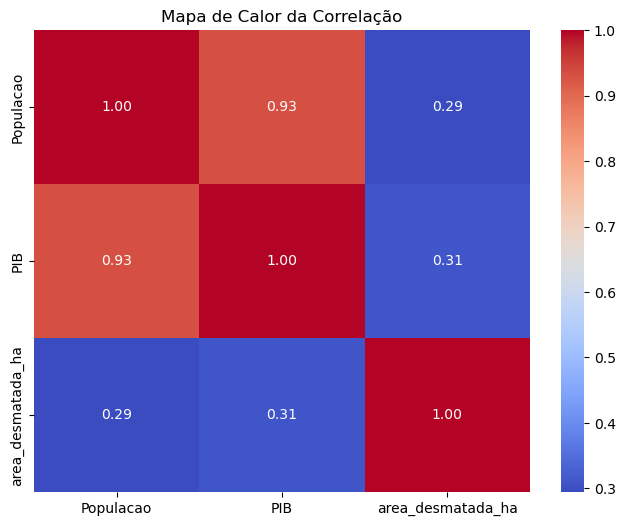

In [152]:
# converte objeto para dataframe
df = pd.DataFrame(df_correlacao_desm_pop_pib)
df['id'] = pd.to_numeric(df['id'], errors='coerce')
df['Populacao'] = pd.to_numeric(df['Populacao'], errors='coerce')
df['PIB'] = pd.to_numeric(df['PIB'], errors='coerce')
df['area_desmatada_ha'] = pd.to_numeric(df['area_desmatada_ha'], errors='coerce')

correlacao = df[['Populacao', 'PIB', 'area_desmatada_ha']].corr(numeric_only=True)

# Criar um mapa de calor para a correlação
plt.figure(figsize=(8, 6))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor da Correlação')
plt.show()